In [2]:
import pandas as pd
import numpy as np
import sklearn as sklearn
from scipy.stats import sem
import statsmodels.api as sm
import itertools

#visualisation libraries
import matplotlib.pyplot as plt 
import seaborn as sns
#settings
%matplotlib inline
pd.set_option('display.max_columns', None) #show all columns
import pickle

seed = 42

The main reason why I chose this problem is my own experience with delayed flights. As a frequent traveller, I have spent many hours at various airports, waiting for delayed flights. I already noticed some basic patterns - flights on busy days are more likely to be delayed, along with flights in wintertime and flights late in the day.<br>
<br>
I will approach the problem as a binary classification problem and try to predict whether a flight will be delayed or not. <br> 

In [7]:
df_2015 = pd.read_csv('df_2015.csv')

In [3]:
#df_2015.to_csv('df_2015_ML.csv') #checkpoint
df_2015 = pd.read_csv('df_2015_ML.csv')
df_2015.drop('Unnamed: 0',inplace=True,axis=1)
df_2015.head(2)
dependent_var = 'ARR_DELAY_15'
#features = [col for col in cols if col !=dependent_var ]

In [4]:
df_2015.head()

,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST_AIRPORT_ID,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE
0,6,4,7,13930,1343.333333,1493.333333,150.0,1,0.0,0.055901,0.164706
1,10,3,7,13204,800.000000,1361.666667,217.0,0,0.0,0.022472,0.098901
2,7,1,0,11618,866.666667,1648.333333,289.0,0,0.0,0.078603,0.267206
3,4,3,0,12953,1825.000000,2273.333333,209.0,0,0.0,0.060976,0.212644
4,9,4,3,14747,1703.333333,1808.333333,123.0,0,0.0,0.040984,0.377953


In [6]:
df_2015.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE
0,6,11,4,7,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,0.0,0.055901,0.164706
1,10,21,3,7,11292,30325,82,13204,31454,33,800.000000,1361.666667,217.0,1546.0,0,0.0,0.022472,0.098901
2,7,27,1,0,14107,30466,81,11618,31703,21,866.666667,1648.333333,289.0,2133.0,0,0.0,0.078603,0.267206
3,4,29,3,0,11298,30194,74,12953,31703,22,1825.000000,2273.333333,209.0,1389.0,0,0.0,0.060976,0.212644
4,9,3,4,3,14869,34614,87,14747,30559,93,1703.333333,1808.333333,123.0,689.0,0,0.0,0.040984,0.377953


In [8]:
df_2015.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,Unnamed: 26
0,2015,2,1,7,AA,1,12478,31703,22,12892,32575,91,900,-3.0,1235,-36.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2015,2,2,1,AA,1,12478,31703,22,12892,32575,91,900,NaN,1235,NaN,1.0,B,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2015,2,3,2,AA,1,12478,31703,22,12892,32575,91,900,-4.0,1235,-8.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2015,2,4,3,AA,1,12478,31703,22,12892,32575,91,900,-5.0,1235,-11.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2015,2,5,4,AA,1,12478,31703,22,12892,32575,91,900,-7.0,1235,-10.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0,NaN


Due to the scope of the problem and the size of the dataset, I will limit the dataset analyzed to top 20 departure and arrival airports and top 10 airlines with most flights. Further down in the analysis, I will also generate binary features for those airlines and airports.
I will further create a sample from this data. The whole dataset has more than 5m row.  <br>

In [9]:
def select_top_X_from_df(df,count_airports = 20,count_airlines=10):
    top_X_origin_airports = df.groupby('ORIGIN_AIRPORT_ID')['MONTH'].count().sort_values(ascending=False).index.tolist()[:count_airports]
    top_X_dest_airports = df.groupby('DEST_AIRPORT_ID')['MONTH'].count().sort_values(ascending=False).index.tolist()[:count_airports]
    top_Y_airlines = df.groupby('UNIQUE_CARRIER')['MONTH'].count().sort_values(ascending=False).index.tolist()[:count_airlines]
    df= df[df['ORIGIN_AIRPORT_ID'].isin(top_X_origin_airports)]
    df = df[df['DEST_AIRPORT_ID'].isin(top_X_dest_airports)]
    df = df[df['UNIQUE_CARRIER'].isin(top_Y_airlines)]
    df.reset_index(inplace=True)
    df.drop('index',inplace=True,axis=1)
    print('Top {} origin airports: {}'.format(count_airports,df['ORIGIN_AIRPORT_ID'].unique()))
    print('Top {} destination airports: {}'.format(count_airports,df['DEST_AIRPORT_ID'].unique()))
    print('Top {} airlines: {}'.format(count_airlines,df['UNIQUE_CARRIER'].unique()))
    return df

In [10]:
df_2015.drop('Unnamed: 26',inplace=True,axis=1)

In [11]:
df_2015 = select_top_X_from_df(df_2015,count_airports = 20,count_airlines=10)

Top 20 origin airports: [12478 12892 14771 10721 11298 14107 13930 10821 11292 13204 14747 11433
 12889 14869 10397 12953 11618 12266 11057 13487]
Top 20 destination airports: [12892 12478 14771 11298 12889 14869 10821 13930 11292 14747 11433 13204
 10721 13487 10397 11618 14107 12953 12266 11057]
Top 10 airlines: ['AA' 'AS' 'B6' 'DL' 'OO' 'US' 'WN' 'UA' 'EV' 'MQ']


In [12]:
df_2015.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS
0,2015,2,1,7,AA,1,12478,31703,22,12892,32575,91,900,-3.0,1235,-36.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0
1,2015,2,2,1,AA,1,12478,31703,22,12892,32575,91,900,NaN,1235,NaN,1.0,B,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0
2,2015,2,3,2,AA,1,12478,31703,22,12892,32575,91,900,-4.0,1235,-8.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0
3,2015,2,4,3,AA,1,12478,31703,22,12892,32575,91,900,-5.0,1235,-11.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0
4,2015,2,5,4,AA,1,12478,31703,22,12892,32575,91,900,-7.0,1235,-10.0,0.0,NaN,395.0,2475.0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
df_2015.shape

(1294584, 26)

In [14]:
def create_sample(df,frac=0.1,seed = seed):
    df = df.sample(n=None, frac=frac, replace=False, weights=None, random_state=seed, axis=None)
    df.reset_index(inplace=True) 
    df.drop('index',inplace=True,axis=1)
    return df

In [15]:
df_2015 = create_sample(df_2015,frac=0.1,seed = 42)

In [16]:
df_2015.shape

(129458, 26)

**Preliminary feature selection**

In [17]:
df_2015.columns #all columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_WAC',
       'DEST_AIRPORT_ID', 'DEST_CITY_MARKET_ID', 'DEST_WAC', 'CRS_DEP_TIME',
       'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'DIV_AIRPORT_LANDINGS'],
      dtype='object')

1) **Creating a binary variable for arrival delay <br>**
I chose to use the 15 minute threshold. In a more detailed analysis, thresholds of 30 or 60 minutes could be used. 

In [18]:
threshold = 15
#data_train['ARR_DELAY_15'] = pd.cut(data_train['ARR_DELAY'], [-1000,threshold,3000],labels=[0,1])
df_2015['ARR_DELAY_{}'.format(threshold)] = (df_2015['ARR_DELAY'] > threshold).astype(int)

To avoid leakage, I will only use features which would be available further in advance. I will therefore exclude all information regarding the delay and information about cancelled flights.

In [19]:
exclude = ["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY", \
    "LATE_AIRCRAFT_DELAY", 'DEP_DELAY','FLIGHTS','ACTUAL_ELAPSED_TIME','CANCELLED','CANCELLATION_CODE','DIV_AIRPORT_LANDINGS']

cols = [col for col in df_2015.columns if col not in exclude]
features = [col for col in cols if col !='ARR_DELAY']
dependent_var = 'ARR_DELAY_15'

In [20]:
df_2015 = df_2015[cols]

In [21]:
df_2015.shape

(129458, 18)

In [22]:
df_2015.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_WAC',
       'DEST_AIRPORT_ID', 'DEST_CITY_MARKET_ID', 'DEST_WAC', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'ARR_DELAY_15'],
      dtype='object')

**Handling missing variables** <br>
I will drop rows with missing arrival delay. The % of missing data is not significant, however, the distribution of NaN values is not random.
Most of the flights with missing arrival delay are cancelled flights. A valid alternative could therefore potentially be to create another model for cancelled flights or consider cancelled flights as delayed. 

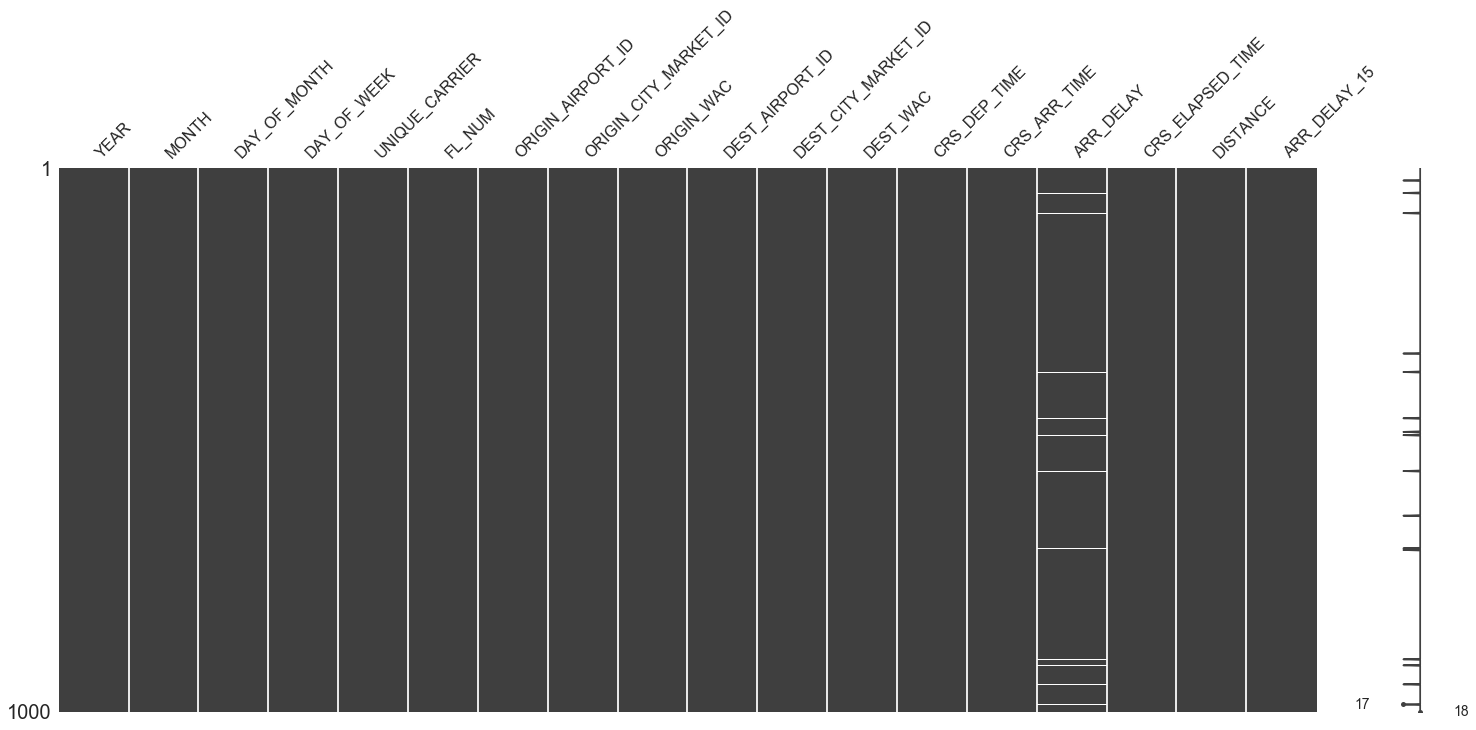

In [23]:
import missingno as msno
  # fake loading function
msno.matrix(df_2015.sample(1000))

In [24]:
df_2015.isnull()['ARR_DELAY'].sum()/df_2015.isnull()['ARR_DELAY'].count()

0.015163218959044633

In [25]:
df_2015.dropna(inplace=True)

In [26]:
df_2015.drop('ARR_DELAY',inplace=True,axis=1)

In [27]:
df_2015.shape

(127495, 17)

**Feature engineering**

1) Arrival and departure time values are in the format HHMM. I will modify the arrival and departure time values to make them continuous.

In [28]:
df_2015['CRS_ARR_TIME'] = df_2015['CRS_ARR_TIME']//100*100+df_2015['CRS_ARR_TIME']%100/60*100
df_2015['CRS_DEP_TIME'] = df_2015['CRS_DEP_TIME']//100*100+df_2015['CRS_DEP_TIME']%100/60*100

In [29]:
df_2015.head(2)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15
0,2015,6,11,4,UA,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1
1,2015,10,21,3,UA,1904,11292,30325,82,13204,31454,33,800.000000,1361.666667,217.0,1546.0,0


2) Add a flag for holidays. In the preliminary analysis I identified major US holidays. I assume that people travel more the day before and after and holiday, so I will flag those days as well.

In [30]:
holidays = pd.read_csv('US_bank_holidays.csv')

In [31]:
holidays.head(2) # US holidays + one day before and after the holiday, Top 5 holidays are flagged

,Date,Holiday,Bank Holiday,Top 5 holiday
0,1/1/2015,New Year Day,TRUE,1
1,1/19/2015,Martin Luther King Jr. Day,TRUE,0


In [32]:
#select only the date and dummies
holidays = holidays[holidays['Top 5 holiday'] ==1][['Date','Top 5 holiday']] # get a list of days of top holidays

In [33]:
holidays['Date']=pd.to_datetime(holidays['Date'])

In [34]:
holidays.head(2)

,Date,Top 5 holiday
0,2015-01-01,1
4,2015-07-03,1


In [35]:
holidays=holidays.rename(columns = {'Top 5 holiday':'IS_HOLIDAY'})

In [36]:
df_2015['Date']=pd.to_datetime((df_2015.YEAR*10000+df_2015.MONTH*100+df_2015.DAY_OF_MONTH).apply(str),format='%Y%m%d')

In [37]:
df_2015.head(1)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,Date
0,2015,6,11,4,UA,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,2015-06-11


In [38]:
df_2015=pd.merge(df_2015, holidays, how='left', on='Date')

In [39]:
df_2015.head(2)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,Date,IS_HOLIDAY
0,2015,6,11,4,UA,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,2015-06-11,NaN
1,2015,10,21,3,UA,1904,11292,30325,82,13204,31454,33,800.000000,1361.666667,217.0,1546.0,0,2015-10-21,NaN


In [40]:
df_2015.isnull().sum()>0

YEAR                     False
MONTH                    False
DAY_OF_MONTH             False
DAY_OF_WEEK              False
UNIQUE_CARRIER           False
FL_NUM                   False
ORIGIN_AIRPORT_ID        False
ORIGIN_CITY_MARKET_ID    False
ORIGIN_WAC               False
DEST_AIRPORT_ID          False
DEST_CITY_MARKET_ID      False
DEST_WAC                 False
CRS_DEP_TIME             False
CRS_ARR_TIME             False
CRS_ELAPSED_TIME         False
DISTANCE                 False
ARR_DELAY_15             False
Date                     False
IS_HOLIDAY                True
dtype: bool

In [41]:
df_2015.fillna(0,inplace=True);
df_2015.drop('Date',inplace=True,axis=1)

In [42]:
df_2015.groupby('IS_HOLIDAY').count()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15
IS_HOLIDAY,,,,,,,,,,,,,,,,,
0.0,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949,122949
1.0,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546,4546


3) Manually generate new features AVG_ARR_DELAY_RATE and CANCEL_RATE for each flight number from the 2014 data, assuming that past delays and cancellations are predictors of future delays.

In [44]:
df_2014 = pd.read_csv('df_2014.csv')

In [45]:
df_2014=create_sample(df_2014,frac=0.1,seed = 42)

In [46]:
canc_df = df_2014[['CANCELLED','FL_NUM','MONTH']].groupby(['FL_NUM','CANCELLED']).count().unstack()
canc_df = canc_df['MONTH'][canc_df['MONTH']>0]
canc_df.fillna(0,inplace=True)

In [47]:
canc_df.head(2)

CANCELLED,0.0,1.0
FL_NUM,,
1,177.0,15.0
2,213.0,11.0


In [48]:
canc_df = canc_df[1.0]/canc_df[0.0]
canc_df = canc_df.reset_index()
canc_df = canc_df.rename(columns={0: 'CANCEL_RATE'});

In [49]:
canc_df.head(1)

,FL_NUM,CANCEL_RATE
0,1,0.084746


In [50]:
df_2015 = pd.merge(df_2015,canc_df,how='left',on='FL_NUM')

In [51]:
df_2015.head(1)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE
0,2015,6,11,4,UA,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,0.0,0.055901


In [52]:
df_2014['ARR_DELAY_{}'.format(threshold)] = (df_2014['ARR_DELAY'] > threshold).astype(int)

In [53]:
df_delay =df_2014[['ARR_DELAY_{}'.format(threshold),'FL_NUM']].groupby(['FL_NUM']).sum()/df_2014[['ARR_DELAY_{}'.format(threshold),'FL_NUM']].groupby(['FL_NUM']).count()

In [57]:
df_delay.rename(columns={'ARR_DELAY_{}'.format(threshold):'AVG_ARR_DELAY_RATE'},inplace=True)
df_delay.reset_index(inplace=True)

In [58]:
df_delay.head(2)

,index,FL_NUM,AVG_ARR_DELAY_RATE
0,0,1,0.156250
1,1,2,0.102679


In [59]:
df_2015 = pd.merge(df_2015,df_delay,how='left',on='FL_NUM')

In [62]:
del df_2014
del df_delay

In [65]:
#df_2015.drop('index',inplace=True,axis=1)
df_2015.head(2)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE
0,2015,6,11,4,UA,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,0.0,0.055901,0.164706
1,2015,10,21,3,UA,1904,11292,30325,82,13204,31454,33,800.000000,1361.666667,217.0,1546.0,0,0.0,0.022472,0.098901


6) **Label encoding** <br> 
Scikit learn cannot handle string features. Before further analysis, I will vectorize categorical features using LabelEncoder. Another option would be to use panda's factorize method.

In [66]:
df_2015.dtypes

YEAR                       int64
MONTH                      int64
DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
UNIQUE_CARRIER            object
FL_NUM                     int64
ORIGIN_AIRPORT_ID          int64
ORIGIN_CITY_MARKET_ID      int64
ORIGIN_WAC                 int64
DEST_AIRPORT_ID            int64
DEST_CITY_MARKET_ID        int64
DEST_WAC                   int64
CRS_DEP_TIME             float64
CRS_ARR_TIME             float64
CRS_ELAPSED_TIME         float64
DISTANCE                 float64
ARR_DELAY_15               int32
IS_HOLIDAY               float64
CANCEL_RATE              float64
AVG_ARR_DELAY_RATE       float64
dtype: object

In [67]:
to_encode = df_2015.select_dtypes(include=['object'], exclude=None).columns

In [68]:
to_encode.tolist()

['UNIQUE_CARRIER']

In [69]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
#data_train[to_encode]= data_train[to_encode].apply(le.fit_transform)
dd = defaultdict(LabelEncoder)
#encode
le_fit = df_2015[to_encode.tolist()].apply(lambda x: dd[x.name].fit_transform(x))
# How to inverse the encoding
df_2015[to_encode.tolist()] = le_fit
# to reverse:
#le_fit.apply(lambda x: dd[x.name].inverse_transform(x))         

In [70]:
df_2015.head(2)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_WAC,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE
0,2015,6,11,4,7,1139,11618,31703,21,13930,30977,41,1343.333333,1493.333333,150.0,719.0,1,0.0,0.055901,0.164706
1,2015,10,21,3,7,1904,11292,30325,82,13204,31454,33,800.000000,1361.666667,217.0,1546.0,0,0.0,0.022472,0.098901


In [71]:
df_2015[df_2015==np.inf].sum()

YEAR                     NaN
MONTH                    NaN
DAY_OF_MONTH             NaN
DAY_OF_WEEK              NaN
UNIQUE_CARRIER           NaN
FL_NUM                   NaN
ORIGIN_AIRPORT_ID        NaN
ORIGIN_CITY_MARKET_ID    NaN
ORIGIN_WAC               NaN
DEST_AIRPORT_ID          NaN
DEST_CITY_MARKET_ID      NaN
DEST_WAC                 NaN
CRS_DEP_TIME             NaN
CRS_ARR_TIME             NaN
CRS_ELAPSED_TIME         NaN
DISTANCE                 NaN
ARR_DELAY_15             NaN
IS_HOLIDAY               NaN
CANCEL_RATE              inf
AVG_ARR_DELAY_RATE       NaN
dtype: float64

In [77]:
df_2015.drop('FL_NUM',inplace=True,axis=1)

In [72]:
df_2015.replace([np.inf, -np.inf], 0,inplace=True); #remove infinite values

In [73]:
print(np.any(np.isnan(df_2015))) #whoops, the dataset seems to have some null values
print(np.all(np.isfinite(df_2015)))

True
False


In [74]:
df_2015.replace(np.nan,0,inplace=True) #replace nulls with 0

In [75]:
print(np.any(np.isnan(df_2015))) # no null values

False


**Further feature selection**

I will check pairwise correlation between variables to identify and remove highly correlated features from the model. The information they provide will likely bring more noise than signal. This is not as important for models such as random forest.

In [ ]:
features = [col for col in df_2015.columns if col !=dependent_var] # update the list of features

In [ ]:
corr_list = []
threshold = 0.5
for i,column_i in enumerate(features):
    for j,column_j in enumerate(features):
        if j>i:     #to make sure we do not count one correlation twice
            if abs(df_2015[features].corr().loc[column_i,column_j]) >=threshold:
                #print(data_train[features].corr().loc[column_i,column_j])
                corr_list.append([df_2015[features].corr().loc[column_i,column_j],column_i, column_j])

In [ ]:
corr_list

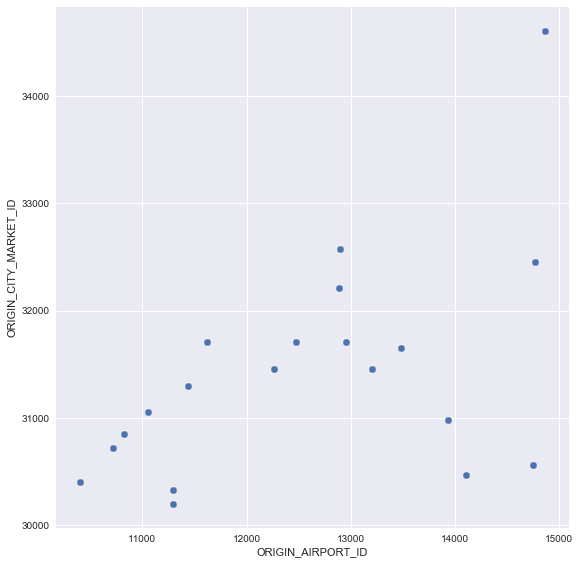

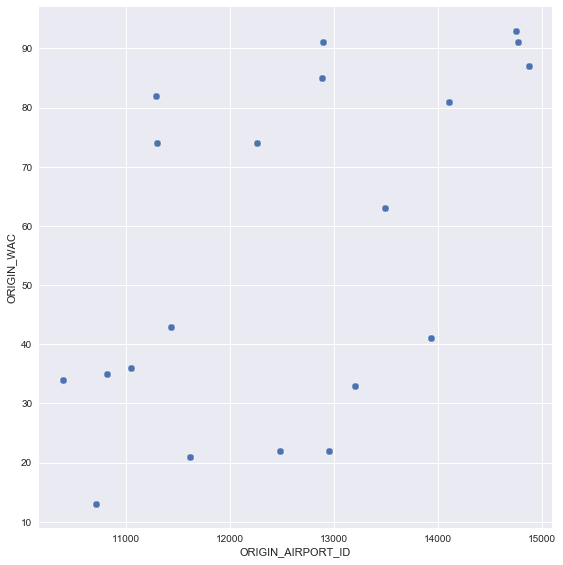

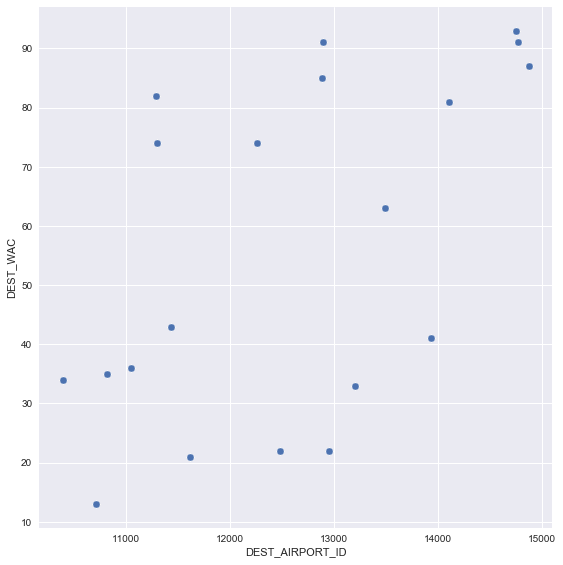

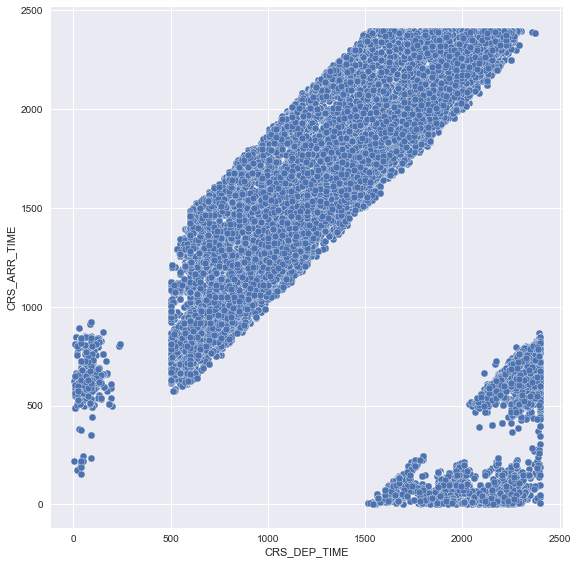

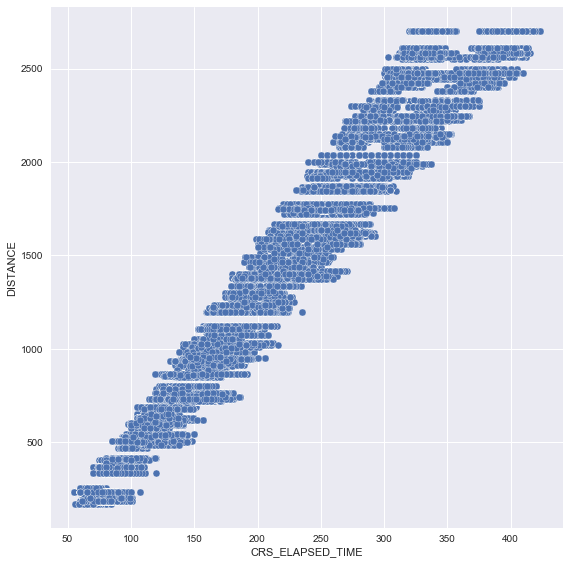

In [170]:
for corr, col1,col2 in corr_list:
    sns.pairplot(df_2015,size=8,x_vars=col1,y_vars=col2)
    plt.show()

**Select K best** <br>
First off, I need to exclude any zero variance features. 
In this case, one of the features (year) is a constant since I only downloaded data for 2015. I will therefore exclude it from the dataset.

In [86]:
df_2015.loc[:,df_2015.apply(pd.Series.nunique) == 1].head(2)

,YEAR
0,2015
1,2015


In [87]:
df_2015 = df_2015.loc[:,df_2015.apply(pd.Series.nunique) != 1]

In [88]:
dependent_var

'ARR_DELAY_15'

In [89]:
features = [col for col in df_2015.columns if col !=dependent_var] # update the list of features

In [92]:
features = [col for col in df_2015.columns if col !=dependent_var] # update the list of features

In [93]:
k_best_list = list()
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
for k_best in (range(len(features))):
    selector = SelectKBest(score_func=f_classif, k=k_best+1)
    selector.fit_transform(df_2015[features], df_2015[dependent_var])
    idxs_selected = selector.get_support(indices=True)
    best_features = np.where(selector.get_support())[0]
# Create new dataframe with only desired columns, or overwrite existing
    print('k={} best: {}'.format(k_best+1,df_2015.columns[idxs_selected]))
    [k_best_list.append(col) for col in df_2015.columns[idxs_selected]]

k=1 best: Index(['CRS_DEP_TIME'], dtype='object')
k=2 best: Index(['CRS_DEP_TIME', 'CRS_ARR_TIME'], dtype='object')
k=3 best: Index(['MONTH', 'CRS_DEP_TIME', 'CRS_ARR_TIME'], dtype='object')
k=4 best: Index(['MONTH', 'UNIQUE_CARRIER', 'CRS_DEP_TIME', 'CRS_ARR_TIME'], dtype='object')
k=5 best: Index(['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'CRS_DEP_TIME',
       'CRS_ARR_TIME'],
      dtype='object')
k=6 best: Index(['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'DISTANCE'],
      dtype='object')
k=7 best: Index(['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE'],
      dtype='object')
k=8 best: Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE'],
      dtype='object')
k=9 best: Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTA

This is hard to read -  I will use counter to count how many times each feature showed up.

In [94]:
from collections import Counter
Counter(k_best_list)

Counter({'ARR_DELAY_15': 9,
         'CANCEL_RATE': 6,
         'CRS_ARR_TIME': 16,
         'CRS_DEP_TIME': 17,
         'CRS_ELAPSED_TIME': 11,
         'DAY_OF_MONTH': 10,
         'DAY_OF_WEEK': 13,
         'DEST_AIRPORT_ID': 5,
         'DEST_CITY_MARKET_ID': 7,
         'DEST_WAC': 2,
         'DISTANCE': 12,
         'IS_HOLIDAY': 8,
         'MONTH': 15,
         'ORIGIN_AIRPORT_ID': 1,
         'ORIGIN_CITY_MARKET_ID': 4,
         'ORIGIN_WAC': 3,
         'UNIQUE_CARRIER': 14})

Feature selection is an iterative process, I will go back and edit the list of variables to use. I will perform further feature selection using decision tree (see below in the next section).  <br>
<br>
In the decision tree models, CRS_DEP_TIME,MONTH, DAY OF MONTH, UNIQUE CARRIER,DAY OF WEEK, ORIGIN WAC, DEST WAC are the most important features. 

DEST CITY MARKET ID, ORIGIN CITY MARKET ID,DISTANCE,ORIGIN AIRPORT ID are among the least important ones. 

Considering the feature importance and number of categorical variables (i.e. there are too many distinct FL_NUM's, which is why I used average cancellation and delay rate per flight instead), I will continue with the following set of features:

In [6]:
to_drop = ['DISTANCE','ORIGIN_CITY_MARKET_ID','DEST_CITY_MARKET_ID','DEST_WAC','ORIGIN_WAC','DAY_OF_MONTH','ORIGIN_AIRPORT_ID']
cols  = [col for col in df_2015.columns if col not in to_drop]

In [7]:
print(cols)

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ARR_DELAY_15', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE']


All of this information will be known well in advance of the flight.

In [8]:
features = [col for col in cols if col != dependent_var]

In [9]:
print(features)

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE']


In [10]:
df_2015 = df_2015[cols]

In [11]:
print(cols)

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ARR_DELAY_15', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE']


In [12]:
df_2015.dtypes

MONTH                   int64
DAY_OF_WEEK             int64
UNIQUE_CARRIER          int64
DEST_AIRPORT_ID         int64
CRS_DEP_TIME          float64
CRS_ARR_TIME          float64
CRS_ELAPSED_TIME      float64
ARR_DELAY_15            int64
IS_HOLIDAY            float64
CANCEL_RATE           float64
AVG_ARR_DELAY_RATE    float64
dtype: object

In [7]:
df_2015 = df_2015[cols]

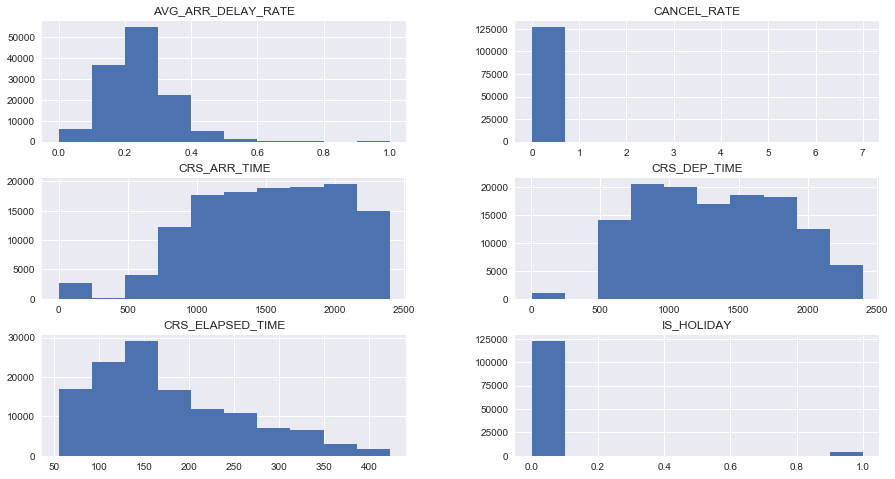

In [160]:
df_2015[df_2015.dtypes[(df_2015.dtypes=="float64")].index.values].hist(figsize=[15,8]);

I will dummy encode the integer columns. On the float columns, I will try use either MinMaxScaler or 
StandardScaler when needed (hence the name "scaleable features")

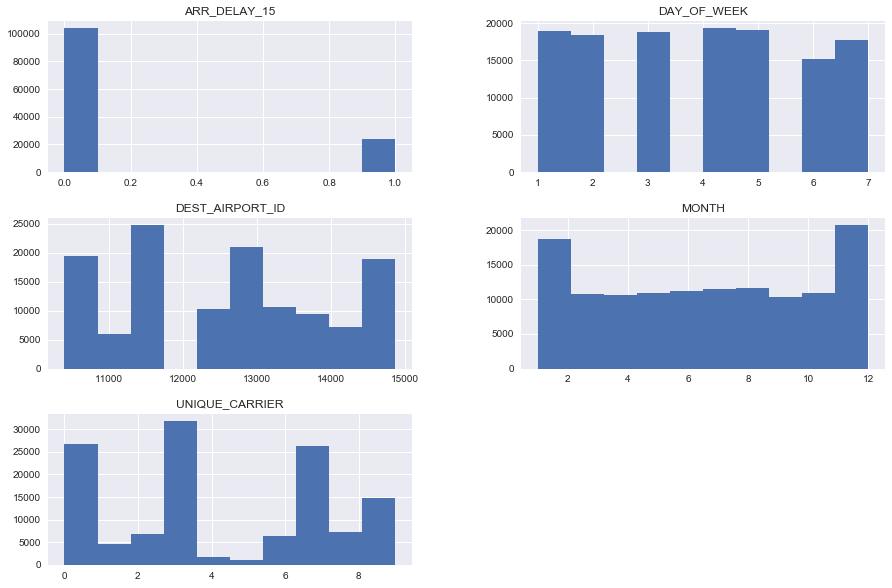

In [161]:
df_2015[df_2015.dtypes[(df_2015.dtypes=="int64")].index.values].hist(figsize=[15,10]);

In [13]:
categ_features = df_2015.dtypes[features][(df_2015.dtypes[features]=="int64")].index.tolist()

In [14]:
print(categ_features)

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID']


In [15]:
scaleable_features = [col for col in df_2015.columns if col not in categ_features+[dependent_var]]
#scaleable_features = [col for col in data_train.columns if col != dependent_var]

In [16]:
print(scaleable_features)

['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE']


In [17]:
# create dummies for each categorical variable; leave 1 level as a reference 
#df_enc = data_train[[col for col in data_train.columns if col not in scaleable_features]]
#append dummies
for categ_feature in categ_features:
    df_dummies = pd.get_dummies(df_2015[categ_feature])
    df_dummies.rename(columns=lambda x:categ_feature+'_'+str(x),inplace=True)
    #df_enc = pd.concat([df_enc,df_dummies.ix[:,:-1]],axis=1) 
    df_2015 = pd.concat([df_2015,df_dummies.ix[:,:-1]],axis=1) 
    #dummy_leave_out.append(df_2015.columns[-1])

In [18]:
df_2015.head(2)

,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST_AIRPORT_ID,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,ARR_DELAY_15,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,UNIQUE_CARRIER_0,UNIQUE_CARRIER_1,UNIQUE_CARRIER_2,UNIQUE_CARRIER_3,UNIQUE_CARRIER_4,UNIQUE_CARRIER_5,UNIQUE_CARRIER_6,UNIQUE_CARRIER_7,UNIQUE_CARRIER_8,DEST_AIRPORT_ID_10397,DEST_AIRPORT_ID_10721,DEST_AIRPORT_ID_10821,DEST_AIRPORT_ID_11057,DEST_AIRPORT_ID_11292,DEST_AIRPORT_ID_11298,DEST_AIRPORT_ID_11433,DEST_AIRPORT_ID_11618,DEST_AIRPORT_ID_12266,DEST_AIRPORT_ID_12478,DEST_AIRPORT_ID_12889,DEST_AIRPORT_ID_12892,DEST_AIRPORT_ID_12953,DEST_AIRPORT_ID_13204,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771
0,6,4,7,13930,1343.333333,1493.333333,150.0,1,0.0,0.055901,0.164706,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,10,3,7,13204,800.000000,1361.666667,217.0,0,0.0,0.022472,0.098901,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [107]:
#print(dummy_leave_out)

In [108]:
print(features) # features without dummies

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE']


In [19]:
print(categ_features) # only categ features

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID']


In [19]:
# create a list of features which includes dummies and excludes categ_features
dummy_features = [col for col in df_2015.columns if col not in [dependent_var]+\
                  categ_features]

In [20]:
df_2015[dummy_features].head(2)  

,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,UNIQUE_CARRIER_0,UNIQUE_CARRIER_1,UNIQUE_CARRIER_2,UNIQUE_CARRIER_3,UNIQUE_CARRIER_4,UNIQUE_CARRIER_5,UNIQUE_CARRIER_6,UNIQUE_CARRIER_7,UNIQUE_CARRIER_8,DEST_AIRPORT_ID_10397,DEST_AIRPORT_ID_10721,DEST_AIRPORT_ID_10821,DEST_AIRPORT_ID_11057,DEST_AIRPORT_ID_11292,DEST_AIRPORT_ID_11298,DEST_AIRPORT_ID_11433,DEST_AIRPORT_ID_11618,DEST_AIRPORT_ID_12266,DEST_AIRPORT_ID_12478,DEST_AIRPORT_ID_12889,DEST_AIRPORT_ID_12892,DEST_AIRPORT_ID_12953,DEST_AIRPORT_ID_13204,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771
0,1343.333333,1493.333333,150.0,0.0,0.055901,0.164706,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,800.000000,1361.666667,217.0,0.0,0.022472,0.098901,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


**Scalers** <br>
Some methods require scaling - I will initialize scalers

In [21]:
# initialize scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sca = StandardScaler()
mms = MinMaxScaler()

#print(scaleable_features)
#print(categ_features)
from sklearn_pandas import DataFrameMapper

# create a mapper object to only scale scaleable features and not categ
mapper_sca_nodummies = DataFrameMapper(
    [(col, None) for col in categ_features] +
    [(col,sca) for col in scaleable_features]
)
print('-----')

print(mapper_sca_nodummies)
mapper_sca_dummies = DataFrameMapper(
    [(col, None) for col in [col for col in dummy_features if col not in categ_features]] +
    [(col, sca) for col in scaleable_features]
)
print('-----')
print(mapper_sca_dummies)

-----
DataFrameMapper(default=False, df_out=False,
        features=[('MONTH', None, {}), ('DAY_OF_WEEK', None, {}), ('UNIQUE_CARRIER', None, {}), ('DEST_AIRPORT_ID', None, {}), ('CRS_DEP_TIME', StandardScaler(copy=True, with_mean=True, with_std=True), {}), ('CRS_ARR_TIME', StandardScaler(copy=True, with_mean=True, with_std=True), {}), ('CRS_ELAPSED_TIME', ...td=True), {}), ('AVG_ARR_DELAY_RATE', StandardScaler(copy=True, with_mean=True, with_std=True), {})],
        input_df=False, sparse=False)
-----
DataFrameMapper(default=False, df_out=False,
        features=[('CRS_DEP_TIME', None, {}), ('CRS_ARR_TIME', None, {}), ('CRS_ELAPSED_TIME', None, {}), ('IS_HOLIDAY', None, {}), ('CANCEL_RATE', None, {}), ('AVG_ARR_DELAY_RATE', None, {}), ('MONTH_1', None, {}), ('MONTH_2', None, {}), ('MONTH_3', None, {}), ('MONTH_4', None, {}), ('MONTH_5', None, {}), ...td=True), {}), ('AVG_ARR_DELAY_RATE', StandardScaler(copy=True, with_mean=True, with_std=True), {})],
        input_df=False, sparse=Fal

**Principal component analysis** <br>
 Most of the available features are categorical and do not have a natural ordering.  Nevertheless, I will try to use PCA and truncated SVD to visualize clusters delayed and non delayed fligths .<br>

[ 15.87354868  12.22185814  11.24991381  10.57011422  10.07127949]
PC1 - PC1 explain 16.0 % of the variance
PC2 - PC2 explain 28.0 % of the variance
PC3 - PC3 explain 39.0 % of the variance
PC4 - PC4 explain 50.0 % of the variance
PC5 - PC5 explain 60.0 % of the variance


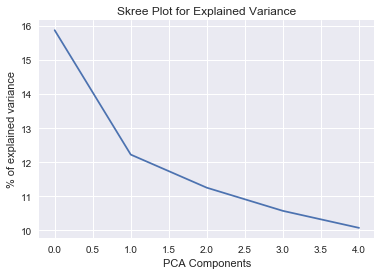

In [139]:
# PCA
n_components = 5
pca = sklearn.decomposition.PCA(n_components=n_components)
pipeline = Pipeline([
    ('sca', sca),
    ('pca', pca)])
df_2d = pipeline.fit_transform(df_2015[features],df_2015[dependent_var])

# we make a scree plot to see how many Principal Components to consider
#fig = plt.figure(figsize=(12, 6))
eig = pipeline.named_steps['pca'].explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = pipeline.named_steps['pca'].explained_variance_ratio_.cumsum()*100.

plt.plot(pipeline.named_steps['pca'].explained_variance_ratio_*100);
plt.title("Skree Plot for Explained Variance")
plt.ylabel("% of explained variance")
plt.xlabel("PCA Components")
print(pipeline.named_steps['pca'].explained_variance_ratio_*100)

for i in range(5):
    
    print('PC{} - PC{} explain {} % of the variance'.format(i+1,i+1,round(var_exp[i]),1))

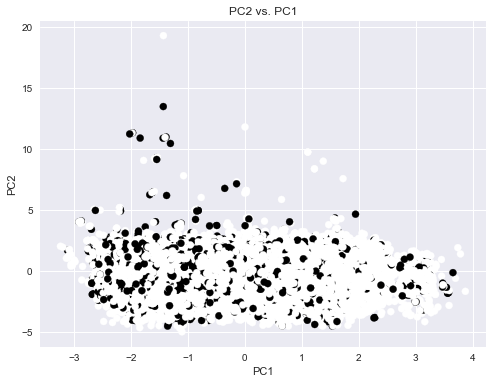

In [140]:
plt.figure(figsize=(8, 6))    
plt.scatter(df_2d[:,0], df_2d[:,1], c=df_2015[dependent_var], s = 50)
plt.ylabel('PC2' )
plt.xlabel('PC1' )
plt.title("PC2 vs. PC1");

The visualisation is promising - there is a visible cluster of delayed flights on the left hand side.

One more attempt - truncated SVD with dummy features

[ 3.53555418  3.38248499  3.18367511  3.03366672  2.9158528 ]
PC1 - PC1 explain 4.0 % of the variance
PC2 - PC2 explain 7.0 % of the variance
PC3 - PC3 explain 10.0 % of the variance
PC4 - PC4 explain 13.0 % of the variance
PC5 - PC5 explain 16.0 % of the variance


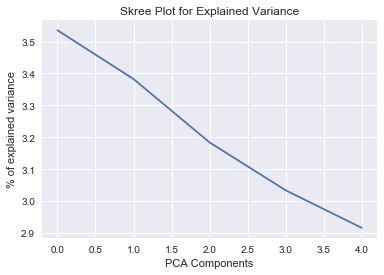

In [142]:
# PCA
n_components = 5
pca = sklearn.decomposition.PCA(n_components=n_components)
pipeline = Pipeline([
    ('sca', sca),
    ('pca', pca)])
df_2d = pipeline.fit_transform(df_2015[dummy_features],df_2015[dependent_var])

# we make a scree plot to see how many Principal Components to consider
#fig = plt.figure(figsize=(12, 6))
eig = pipeline.named_steps['pca'].explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = pipeline.named_steps['pca'].explained_variance_ratio_.cumsum()*100.

plt.plot(pipeline.named_steps['pca'].explained_variance_ratio_*100);
plt.title("Skree Plot for Explained Variance")
plt.ylabel("% of explained variance")
plt.xlabel("PCA Components")
print(pipeline.named_steps['pca'].explained_variance_ratio_*100)

for i in range(5):
    
    print('PC{} - PC{} explain {} % of the variance'.format(i+1,i+1,round(var_exp[i]),1))

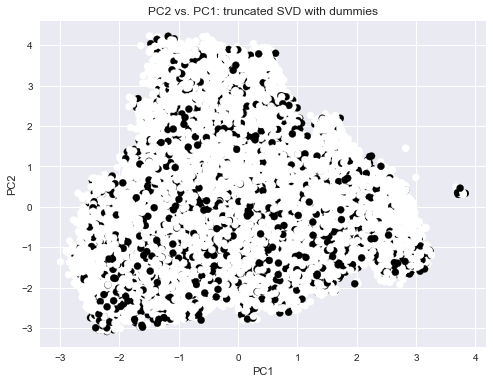

In [143]:
plt.figure(figsize=(8, 6))    
plt.scatter(df_2d[:,0], df_2d[:,1], c=df_2015[dependent_var], s = 50)
plt.ylabel('PC2' )
plt.xlabel('PC1' )
plt.title("PC2 vs. PC1: truncated SVD with dummies");

**Model - functions**

In [22]:
def do_grid_search(pipeline,X_train,y_train,parameter_grid,scoring_method = 'roc_auc',cv=5,seed=42):
    """
    Perform grid search
    -----
    Inputs:
    pipeline
    X_train: features
    y_train: dependent variable
    parameter grid: dictionary
    scoring_method: default value: 'roc_auc'
    cv: defaul value: 5
    """
    
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid=parameter_grid,cv=cv,scoring=scoring_method)
    grid_result = grid_search.fit(X_train, y_train)
    print("Performing grid search...")
    # summarize results
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("Best cross-validation score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print("Best parameter set:")
    best_estimator = grid_result.best_estimator_
    best_parameters = best_estimator.get_params()
    for param_name in sorted(parameter_grid.keys()):
        print('{}: {}'.format(param_name, best_parameters[param_name]))
    return {'grid_result':grid_result,'best_estimator':best_estimator}

def evaluate_model(y_test,y_pred,y_proba,description=None):
    """ 
     Evaluate model
    ----------
    Inputs
    ------
    y_pred: predicted values (list of binary values)
    y_test: actual values
    y_proba: list of probabilities
    Description: string 
    """
    
    from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, recall_score,precision_score, precision_recall_curve
    import sklearn.metrics as metrics
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    
    #if description is not None:
       #name = description
    #elif pipeline is not None:
       #name = pipeline.named_steps['clf'].__class__.__name__
    #else:
        #name = ""
    #classification report
    
    print('Classification report on testing data')
    target_names = ['On time', 'Delayed']
    classif_report = classification_report(y_test, y_pred,target_names=target_names)
    print(classif_report) 
    #plot confusion matrix
    print('Confusion matrix')
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm)
    

    return pd.DataFrame({'precision':precision_score(y_test, y_pred),
            'recall':recall_score(y_test, y_pred),
           'f1-score':f1_score(y_test, y_pred),
           'accuracy':accuracy_score(y_test,y_pred),
           'roc_auc_score':roc_auc_score(y_test,y_proba)},index=[description])

def plot_confusion_matrix(cm):
    """ 
    Plots confusion matrix
    ----------
    Input: confusion matrix in format [[1,2][3,4]]
    """
    TP,FP,FN,TN = cm[1][1],cm[0][1],cm[1][0],cm[0][0]
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.colorbar()
    target_names = ['Not Delayed', 'Delayed']
    tick_marks = np.arange(len(target_names))
    plt.text(1,1,'TP: {} ({})'.format(TP,round(TPR,2)),va='center',ha='center',bbox=dict(fc='w'))
    plt.text(0,0,'TN: {} ({})'.format(TN,round(TNR,2)),va='center',ha='center',bbox=dict(fc='w'))
    plt.text(0,1,'FN: {} ({})'.format(FN,round(PPV,2)),va='center',ha='center',bbox=dict(fc='w'))
    plt.text(1,0,'FP: {} ({})'.format(FP,round(NPV,2)),va='center',ha='center',bbox=dict(fc='w'))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.show()


def plot_roc_curve(y_test,y_proba,description=''):
    """ Plot ROC curve
    ----------
    Inputs
    y_test
    y_proba
    pipeline - pipeline
    description - string 
    ----------
    Returns
    ----------
    dictionary of {'FPR':fpr, 'TPR': tpr,'thresholds': thresholds}
    """
    # optimal cutoff point: Sensitivity + Specificity is maximal ??
    from sklearn.metrics import roc_curve, auc,roc_auc_score
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    print("AUC on test data: {}".format(round(auc,2)))
    
    #elif pipeline is not None:
    #    name = pipeline.named_steps[classifier].__class__.__name__
    
    # ROC chart
    plt.grid()
    plt.plot(false_positive_rate, true_positive_rate,'b')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
   
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title("ROC curve for {}".format(description))
    return {'FPR':false_positive_rate,'TPR':true_positive_rate,'thresholds': thresholds}

def plot_precision_recall_f(y_test, y_proba,description=''):
    """ Plot ROC curve
    ----------
    Inputs
    y_test
    y_proba
    description - string 
    ----------
    Returns
    ----------
    false_positive_rate,true_positive_rate, thresholds
    """

    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    thresholds_adjusted = np.append(thresholds, np.nan)
    #print(thresholds_adjusted)
    f_score = 2 * precision * recall / (precision + recall)
    plt.plot(thresholds_adjusted, precision, label='Precision')
    plt.plot(thresholds_adjusted, recall, label='Recall')
    plt.plot(thresholds_adjusted, f_score, label='f-score')
    plt.xlim((0.0, 1.0))
    plt.title(description)
    plt.legend(loc='upper right')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.grid()
    max_f1 = pd.Series(f_score).dropna().max()
    print('Max F1 on testing data: {}'.format(max_f1))
    print('')
    return {'precision':precision,'recall': recall, 'f_score': f_score, 'thresholds':thresholds_adjusted, 'max_f1':max_f1}

def plot_precision_recall_curve(precision,recall):
    precision
    #average_precision = average_precision_score(y_test, y_proba)
    #sklearn.metrics.average_precision_score(y_test, y_proba)
    # Compute micro-average ROC curve and ROC area
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, color='navy',label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    #plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
    plt.legend(loc="lower left")
    plt.show()
    
def dump_pickle_model(result,pickle_name):
    """
    Pickle file
    ---------
    result: output of the do_grid_search function
    pickle_name:str
    """

    import os
    import pickle
    save_models_to = r'C:\Users\micakova\Experiments\Pokusy\Search\models'
    if not os.path.exists(save_models_to):
        os.makedirs(save_models_to)
    pickle_name =  r'\{}.pickle'.format(pickle_name)   
    pickle.dump(result, open(save_models_to+pickle_name, 'wb'))

def optimize_params(name1,name2,result,parameter_grid):
    import matplotlib.pyplot as plt
    """
    Visualise test score in relation to 2 selected parametres
    -----
    Inputs
    -------
    name1,name2: string;name of parameter 1/2 as appearing in parameter_grid
    parameter_grid:dictionary
    result:result of grid_search

    """
    param1=  parameter_grid[name1]
    param2 =  parameter_grid[name2]
    print('parameter 1: {},{}; parameter 2: {},{}'.format(name1,param1,name2,param2))
    print("Best: %f using %s" % (result['grid_result'].best_score_, result['grid_result'].best_params_))
    means = result['grid_result'].cv_results_['mean_test_score']
    #stds = result['grid_result'].cv_results_['std_test_score']
    #params = result['grid_result'].cv_results_['params']
    scores = np.array(means).reshape(len(param2), len(param1))
    for i, value in enumerate(param2):
        plt.plot(param1, scores[i], label='{}: {}'.format(name2,value))
    plt.legend()
    plt.xlabel(name1)
    plt.ylabel('Score')

**Optimizing the threshold value - TBD**

**Model - imports**

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm

C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,train_test_split

In [25]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, recall_score,precision_score, precision_recall_curve
from sklearn.metrics import roc_curve

In [26]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif

#from sklearn.decomposition import PCA
kbst = SelectKBest(chi2)
#pca = PCA()


In [27]:
dependent_var = 'ARR_DELAY_15'
seed=42
# i decreased the number of folds for performance issues
kfold = KFold(n_splits=4, shuffle=True, random_state=seed)
cv=kfold

In [28]:
# check if the names make sense
[col for col in df_2015 if col not in dummy_features+categ_features]

['ARR_DELAY_15']

**Split of the dataset into train and test**

In [29]:
#train test split: whole dataset
seed=42
features = [col for col in df_2015.columns if col != dependent_var]
X_train, X_test, y_train, y_test = train_test_split(df_2015[dummy_features+categ_features], df_2015[dependent_var], test_size=0.5, random_state=seed)

In [30]:
X_train.head(2)

,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,IS_HOLIDAY,CANCEL_RATE,AVG_ARR_DELAY_RATE,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,UNIQUE_CARRIER_0,UNIQUE_CARRIER_1,UNIQUE_CARRIER_2,UNIQUE_CARRIER_3,UNIQUE_CARRIER_4,UNIQUE_CARRIER_5,UNIQUE_CARRIER_6,UNIQUE_CARRIER_7,UNIQUE_CARRIER_8,DEST_AIRPORT_ID_10397,DEST_AIRPORT_ID_10721,DEST_AIRPORT_ID_10821,DEST_AIRPORT_ID_11057,DEST_AIRPORT_ID_11292,DEST_AIRPORT_ID_11298,DEST_AIRPORT_ID_11433,DEST_AIRPORT_ID_11618,DEST_AIRPORT_ID_12266,DEST_AIRPORT_ID_12478,DEST_AIRPORT_ID_12889,DEST_AIRPORT_ID_12892,DEST_AIRPORT_ID_12953,DEST_AIRPORT_ID_13204,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST_AIRPORT_ID
51018,1300.000000,1441.666667,85.0,0.0,0.039604,0.114286,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,1,3,13930
79954,566.666667,681.666667,69.0,0.0,0.019802,0.320388,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,3,10397


In [31]:
print(features)
#print(dummy_features)
#print(dummy_features_leave1out)

['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'IS_HOLIDAY', 'CANCEL_RATE', 'AVG_ARR_DELAY_RATE', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'UNIQUE_CARRIER_0', 'UNIQUE_CARRIER_1', 'UNIQUE_CARRIER_2', 'UNIQUE_CARRIER_3', 'UNIQUE_CARRIER_4', 'UNIQUE_CARRIER_5', 'UNIQUE_CARRIER_6', 'UNIQUE_CARRIER_7', 'UNIQUE_CARRIER_8', 'DEST_AIRPORT_ID_10397', 'DEST_AIRPORT_ID_10721', 'DEST_AIRPORT_ID_10821', 'DEST_AIRPORT_ID_11057', 'DEST_AIRPORT_ID_11292', 'DEST_AIRPORT_ID_11298', 'DEST_AIRPORT_ID_11433', 'DEST_AIRPORT_ID_11618', 'DEST_AIRPORT_ID_12266', 'DEST_AIRPORT_ID_12478', 'DEST_AIRPORT_ID_12889', 'DEST_AIRPORT_ID_12892', 'DEST_AIRPORT_ID_12953', 'DEST_AIRPORT_ID_13204', 'DEST_AIRPORT_ID_13487', 'DEST_AIRPORT_ID_13930', 'DEST_AIRPORT_ID_14107', 'DEST

**Model**

**Notes**

Since the dataset is unbalanced, I will use use roc_auc as an evaluation metric for cross-validation. Accuracy is not suitable for this purpose, seeing as I could reach a rate of more than 80% just by classifying all the flights as non-delayed. I will do a k fold cross-validation with k set to 5. I might decrease this if the calculations take too long. 

**Logistic regression** <br>
I will perform logistic regression with dummy variables. 

In [248]:
name = 'Logit_weighted_wdummies'
clf = LogisticRegression(random_state=seed,n_jobs=-1,max_iter=4000)

scoring_method='roc_auc'

parameter_grid = {
    #'clf__solver': ['sag']
    'clf__class_weight': ['balanced'],
    'clf__penalty':['l1'], #'clf__penalty':['l2','l1'],
    'clf__C': [0.35]
}

pipeline = Pipeline([
    #('kbest',SelectKBest(score_func=f_classif, k=10)),
    #('sca', sca),
    ('clf', clf),
])

result = do_grid_search(pipeline,X_train[dummy_features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv, seed=42)


Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.646157 using {'clf__C': 0.35, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
Best parameter set:
clf__C: 0.35
clf__class_weight: balanced
clf__penalty: l1


Classification report on testing data
             precision    recall  f1-score   support

    On time       0.87      0.60      0.71     51831
    Delayed       0.26      0.62      0.37     11917

avg / total       0.76      0.60      0.65     63748

Confusion matrix


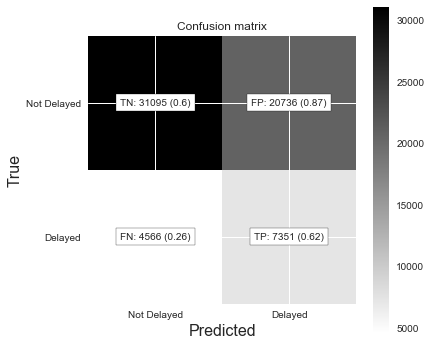

In [249]:
y_proba  = result['best_estimator'].predict_proba(X_test[dummy_features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[dummy_features])
df_result = evaluate_model(y_test,y_pred,y_proba,description='Logistic regression w/dummies')

AUC on test data: 0.65


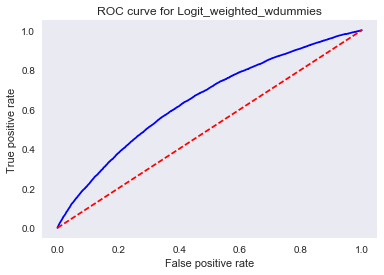

In [250]:
#roc_result = {}
roc_result_ = plot_roc_curve(y_test, y_proba,name)
roc_result[name] = roc_result_
#print(roc_result)
#roc_result = {name:roc_result_}

In [251]:
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

In [252]:
print(name)

Logit_weighted_wdummies


In [253]:
dump_pickle_model(result,name)

In [254]:
pickle_name = name
pickle_location = 'C:\\Users\\micakova\\Experiments\\Pokusy\\Search\\models\\'
model_pickle = pickle.load(open(pickle_location + pickle_name+".pickle", 'rb'))

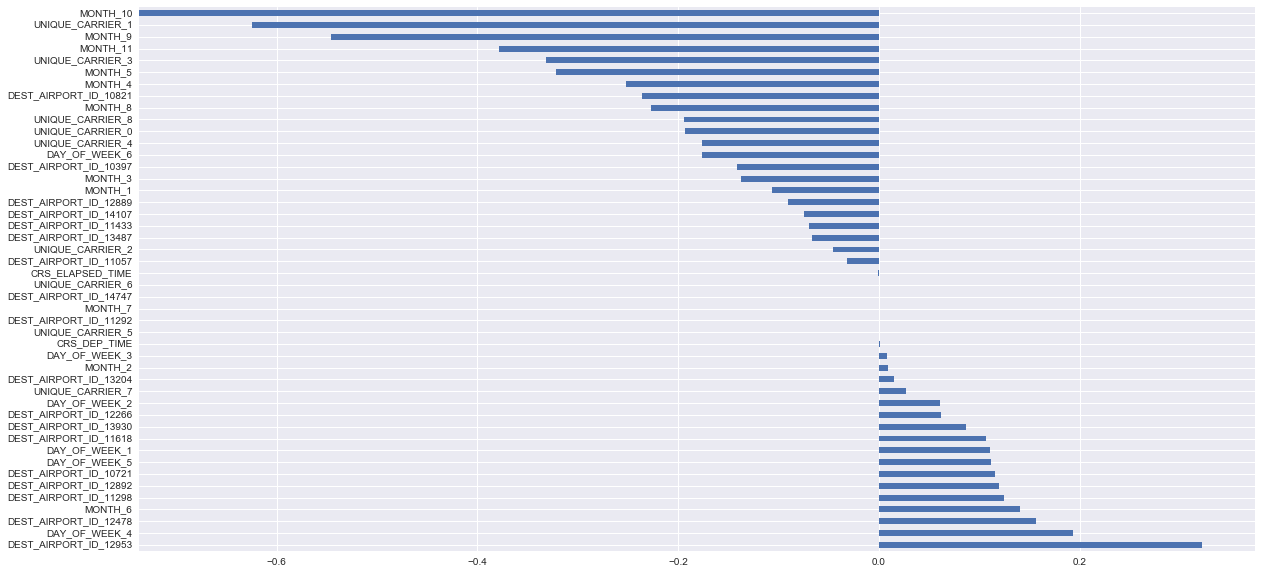

In [952]:
feat_importances = model_pickle['best_estimator'].named_steps['clf'].coef_[0]
feat_importances = pd.Series(data=feat_importances, index=dummy_features_leave1out).sort_values(ascending=False)
feat_importances.plot(kind='barh',figsize=(20,10));

As a quick check, I will calculate the ratio of non-delayed flights to delayed by month. The results of the logistic regression are in line with what I am seeing in the data. 

In [806]:
data_train.groupby(['MONTH','ARR_DELAY_15']).count().unstack()['DAY_OF_WEEK'][1]/data_train.groupby(['MONTH','ARR_DELAY_15']).count().unstack()['DAY_OF_WEEK'][0]

MONTH
1     0.243926
2     0.287355
3     0.236066
4     0.212310
5     0.211430
6     0.319322
7     0.270601
8     0.221146
9     0.148852
10    0.138504
11    0.174997
12    0.261617
dtype: float64

**Unweighted logistic regression with dummies**

In [233]:
description = 'Logit_unweighted_dummies'
clf = LogisticRegression(random_state=seed,n_jobs=-1,max_iter=4000)

scoring_method='roc_auc'

parameter_grid = {
    #'clf__solver': ['sag']
    #'clf__class_weight': ['balanced'],
    'clf__penalty':['l1'],
    'clf__C': [0.5,0.6]
}

pipeline = Pipeline([
    #('kbest',SelectKBest(score_func=f_classif, k=10)),
    #('sca', sca),
    ('clf', clf),
])

result = do_grid_search(pipeline,X_train[dummy_features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv, seed=42)

Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.646049 using {'clf__C': 0.6, 'clf__penalty': 'l1'}
Best parameter set:
clf__C: 0.6
clf__penalty: l1


Classification report on testing data
             precision    recall  f1-score   support

    On time       0.81      1.00      0.90     51831
    Delayed       0.33      0.00      0.00     11917

avg / total       0.72      0.81      0.73     63748

Confusion matrix


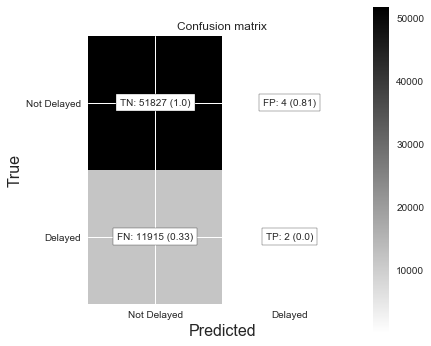

In [234]:
y_proba  = result['best_estimator'].predict_proba(X_test[dummy_features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[dummy_features])
df_result = evaluate_model(y_test,y_pred,y_proba,description=description)

In [235]:
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

AUC on test data: 0.65


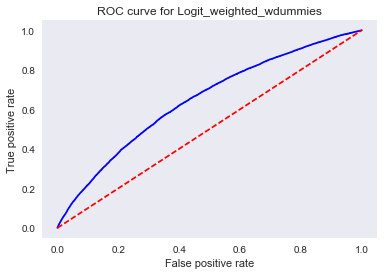

In [239]:
roc_result_ = plot_roc_curve(y_test, y_proba,name)
roc_result[name] = roc_result_

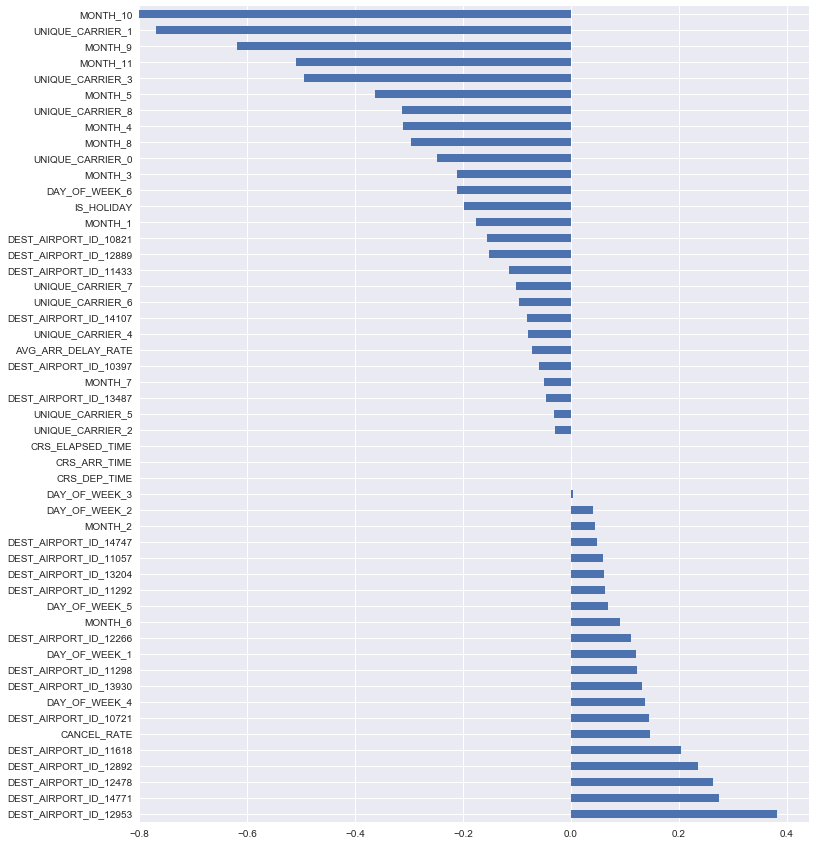

In [174]:
feat_importances = result['best_estimator'].named_steps['clf'].coef_[0]
feat_importances = pd.Series(data=feat_importances, index=dummy_features).sort_values(ascending=False)
feat_importances.plot(kind='barh',figsize=(12,15));

In [175]:
dump_pickle_model(result,name)

**Decision tree classifier**

I will first construct a base decision tree clasifier to help me with feature selection.

In [178]:
name = 'DecisionTree_unweighted_wodummies'
clf = DecisionTreeClassifier()
scoring_method = 'roc_auc'

parameter_grid = {
    'clf__max_depth': [7,8] #values tested: [4,6,8,10,12,14,18,22]
    ,'clf__min_samples_leaf': [500]
}

pipeline = Pipeline([
    #('featurize', mapper), # does not work for CV
    ('clf', clf)])

scoring_method = 'roc_auc'
#scoring_method = 'recall'

result = do_grid_search(pipeline,X_train[features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv, seed=42)

Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.634387 using {'clf__max_depth': 7, 'clf__min_samples_leaf': 500}
Best parameter set:
clf__max_depth: 7
clf__min_samples_leaf: 500


In [179]:
y_proba  = result['best_estimator'].predict_proba(X_test[features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[features])

Classification report on testing data
             precision    recall  f1-score   support

    On time       0.81      1.00      0.90     51831
    Delayed       0.00      0.00      0.00     11917

avg / total       0.66      0.81      0.73     63748

Confusion matrix


C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: RuntimeWarning: invalid value encountered in long_scalars


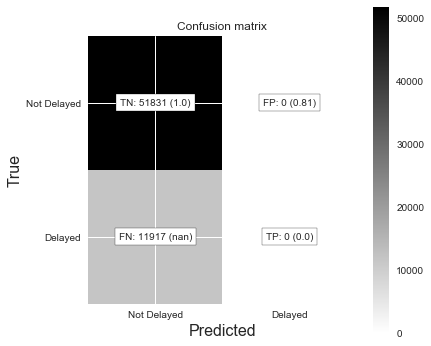

C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [180]:
df_result = evaluate_model(y_test,y_pred,y_proba,description=name)

In [181]:
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

The model predicted no delayed flights as delayed. Plotting the predicted probabilities of a flight being delayed against thresholds, I can see that the threshold of 0.5 is too high. 

Max F1 on testing data: 0.3583416063915284

0.487889273356


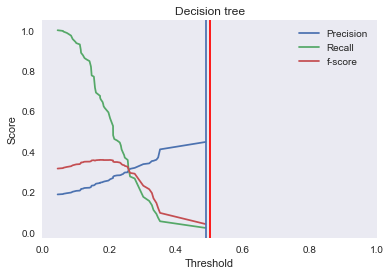

In [182]:
dict_precision_recall_f = plot_precision_recall_f(y_test, y_proba,description='Decision tree')
print(max(dict_precision_recall_f['thresholds']))
plt.axvline(max(dict_precision_recall_f['thresholds']))
plt.axvline(0.5,color='r');

In [183]:
dump_pickle_model(result,name)

AUC on test data: 0.64


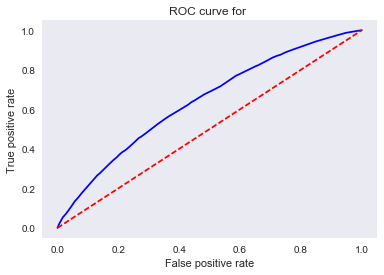

In [184]:
roc_result_ = plot_roc_curve(y_test, y_proba)
roc_result={}
#roc_result = {name:roc_result_}
roc_result[name] = roc_result_
#import json
#print(roc_result)
#with open('data.json', 'w') as f:
#    json.dump(data, f)

**Feature importance and visualisation** <br>

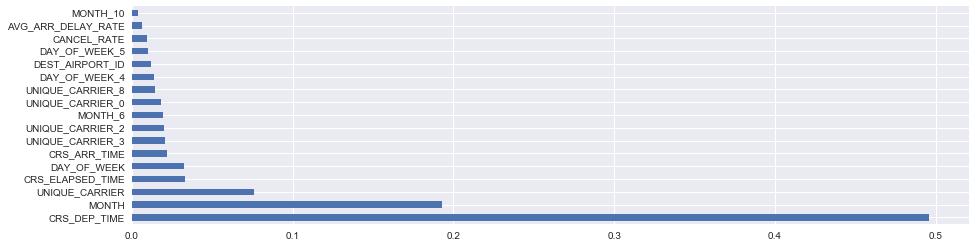

In [185]:
feat_importances = pd.Series(data=result['best_estimator'].named_steps['clf'].feature_importances_, index=features).sort_values(ascending=False)
feat_importances[feat_importances!=0].plot.barh(figsize=(15,4))

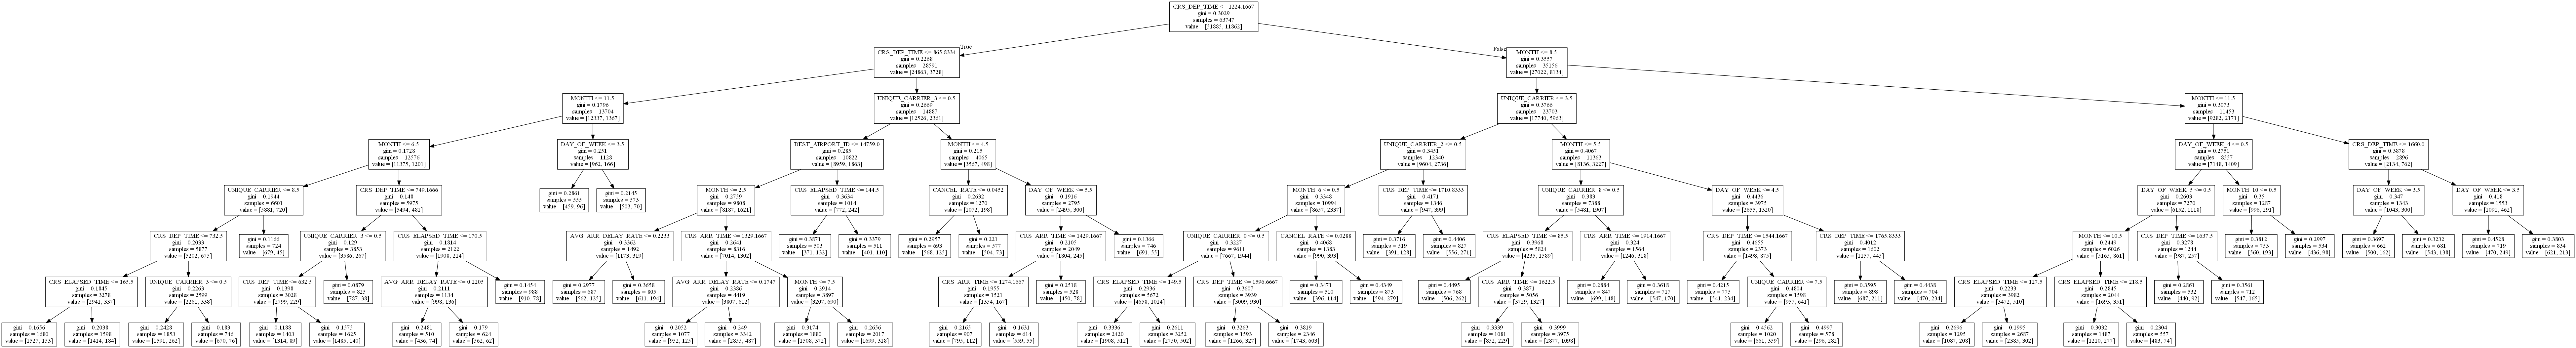

In [186]:
import os
from sklearn import tree
dotfile = open(r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml.dot', 'w')
tree.export_graphviz(result['best_estimator'].named_steps['clf'], out_file = dotfile, feature_names = features)
dotfile.close()
import subprocess
subprocess.call(['dot', '-Tpng','-O',r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml.dot'])
import subprocess
from IPython.display import Image
Image(filename=r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml.dot.png')

I will also contruct another decision tree classifier with dummies. Decision tree should be able to handle categorical features naturally, so I do not expect a performance increase. However, the analysis is useful for identification of top drivers of flight delay. As expected,it seems that the performance with extremely sparse feature matrix is worse, so I will not use the results any further

In [188]:
name = 'DecisionTree_weighted_dummies'

clf = DecisionTreeClassifier()

parameter_grid = {
    'clf__max_depth': [6,7,8,9,10,14,18]
    ,'clf__min_samples_leaf': [200,300,400]
    ,'clf__class_weight':['balanced']
}

pipeline = Pipeline([
    #('featurize', mapper), # does not work for CV
    ('clf', clf)])

scoring_method = 'roc_auc'
#scoring_method = 'recall'
result = do_grid_search(pipeline,X_train[dummy_features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv, seed=42)

Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.629382 using {'clf__class_weight': 'balanced', 'clf__max_depth': 9, 'clf__min_samples_leaf': 300}
Best parameter set:
clf__class_weight: balanced
clf__max_depth: 9
clf__min_samples_leaf: 300


Classification report on testing data
             precision    recall  f1-score   support

    On time       0.87      0.54      0.67     51831
    Delayed       0.24      0.64      0.35     11917

avg / total       0.75      0.56      0.61     63748

Confusion matrix


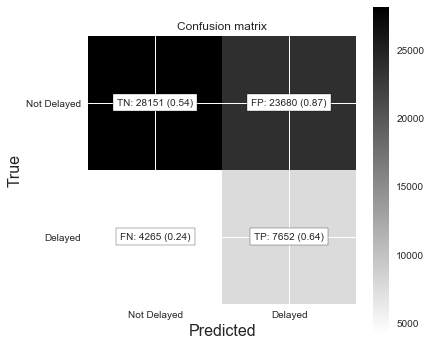

In [190]:
y_proba  = result['best_estimator'].predict_proba(X_test[dummy_features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[dummy_features])
df_result = evaluate_model(y_test,y_pred,y_proba,description=name)

In [191]:
print(df_result)

                               accuracy  f1-score  precision    recall  \
DecisionTree_weighted_dummies  0.561633  0.353858   0.244223  0.642108   

                               roc_auc_score  
DecisionTree_weighted_dummies        0.63051  


In [192]:
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

AUC on test data: 0.63


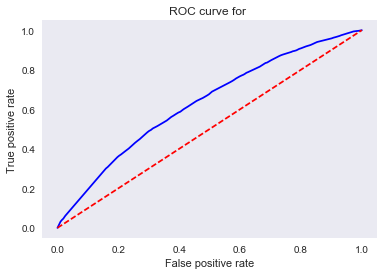

In [193]:
roc_result_ = plot_roc_curve(y_test, y_proba)
#import json
#print(roc_result)
#roc_result = {name:roc_result_}
roc_result[name] = roc_result_

Max F1 on testing data: 0.3538578926680386

0.744460113733


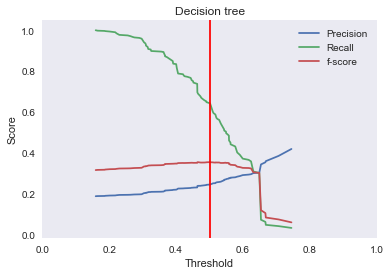

In [194]:
dict_precision_recall_f = plot_precision_recall_f(y_test, y_proba,description='Decision tree')
print(max(dict_precision_recall_f['thresholds']))
#plt.axvline(max(dict_precision_recall_f['thresholds']))
plt.axvline(0.5,color='r');

In [195]:
dump_pickle_model(result,name)

The model can be unpickled in the following way:

In [196]:
save_models_to = 'C:\\Users\\micakova\\Experiments\\Pokusy\\Search\\models\\'
model_pickle = pickle.load(open(save_models_to + name+".pickle", 'rb'))
model_pickle['best_estimator'].named_steps['clf']

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=300,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

**Feature importance** <br>

CRS_DEP_TIME,MONTH, DAY OF MONTH, UNIQUE CARRIER, ORIGIN WAC, DEST WAC,DAY OF WEEK are the most important features. DEST CITY MARKET ID, ORIGIN CITY MARKET ID,DISTANCE,ORIGIN AIRPORT ID are among the least important ones. 

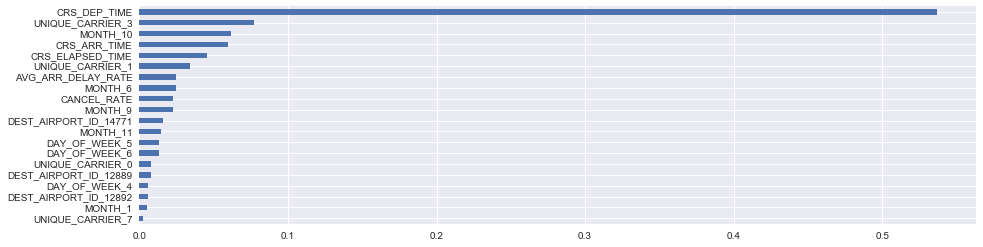

In [198]:
feat_importances = pd.Series(data=result['best_estimator'].named_steps['clf'].feature_importances_, index=dummy_features).sort_values(ascending=True)
feat_importances[feat_importances!=0].plot.barh(figsize=(15,4))

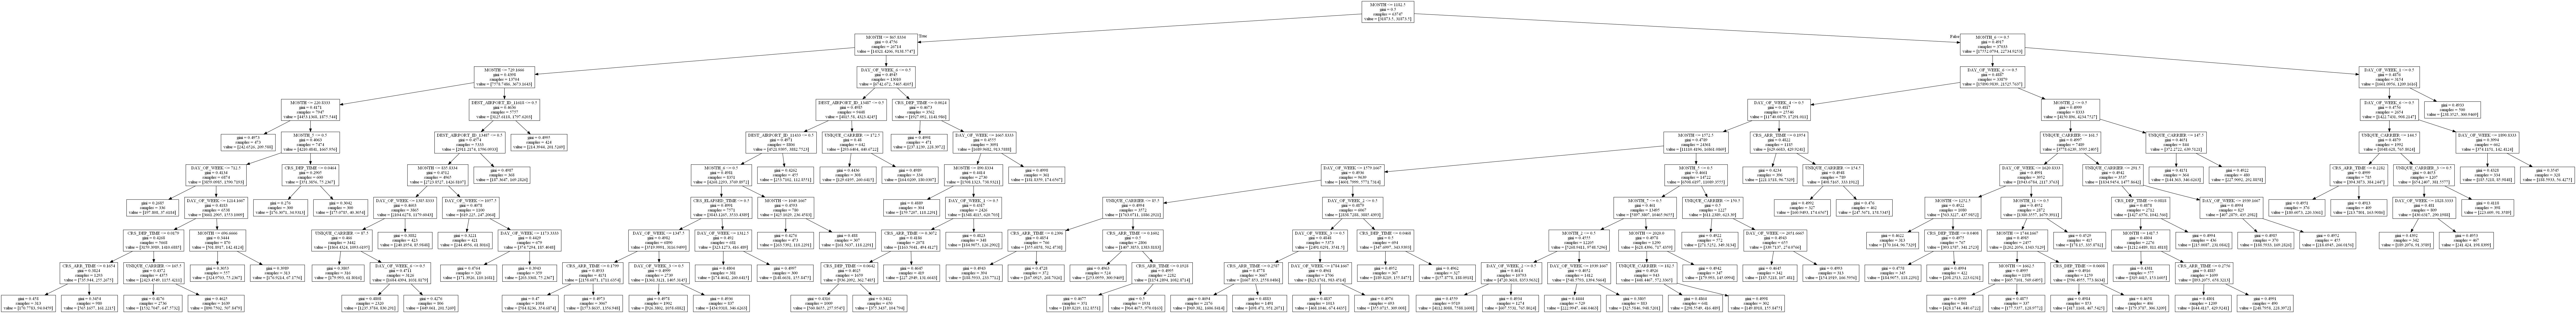

In [199]:
dotfile = open(r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml2.dot', 'w')
tree.export_graphviz(result['best_estimator'].named_steps['clf'], out_file = dotfile, feature_names = features)
dotfile.close()
subprocess.call(['dot', '-Tpng','-O',r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml2.dot'])
Image(filename=r'C:\Users\micakova\Experiments\Pokusy\Search\tree_ml2.dot.png')

In [840]:
feat_importances = pd.Series(data=result['best_estimator'].named_steps['clf'].feature_importances_, index=dummy_features).sort_values(ascending=False)

**Random Forest Classifier**

In [329]:
#clf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Random forest is a suitable model because it can handle categorical features naturally. 
I first tuned the number of max_features for 100 trees (n_estimators) and no restriction on min_samples_leaf. Next, I  tuned the 'min_samples_leaf' parameter.  In general, I start with a few numbers further apart and tweak them by making small changes. In the last step, I increased the number of trees. Optimizing the number of trees could likely bring even better performance, however, increasing the number of trees from 100 to 200 increased OOB score only marginally. 

In [200]:
name = 'Random_forest_balanced_wo_dummies'
#class_weight = None
#verbose = 1
verbose = 0
clf = RandomForestClassifier(oob_score = True,criterion='gini', random_state = seed,n_jobs = 1,verbose=verbose)
parameter_grid = {
    #'clf__max_depth':[50],
    'clf__max_features': [0.85], # 
    'clf__class_weight': ['balanced'],
    'clf__min_samples_leaf': [200], # best out of [100,150,200,250]
    'clf__n_estimators': [200,300] 
}

pipeline = Pipeline([
    ('clf', clf)])

#scoring_method = metrics.roc_auc_score
scoring_method = 'roc_auc'
#scoring_method = 'recall'

result = do_grid_search(pipeline,X_train[features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv,seed=42)

Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.651822 using {'clf__class_weight': 'balanced', 'clf__max_features': 0.85, 'clf__min_samples_leaf': 200, 'clf__n_estimators': 200}
Best parameter set:
clf__class_weight: balanced
clf__max_features: 0.85
clf__min_samples_leaf: 200
clf__n_estimators: 200


In [203]:
#result for  100 trees
#optimize_params('clf__max_features','clf__min_samples_leaf',result,parameter_grid)

parameter 1: clf__max_features,[0.85, 0.9]; parameter 2: clf__n_estimators,[200]
Best: 0.651822 using {'clf__class_weight': 'balanced', 'clf__max_features': 0.85, 'clf__min_samples_leaf': 200, 'clf__n_estimators': 200}


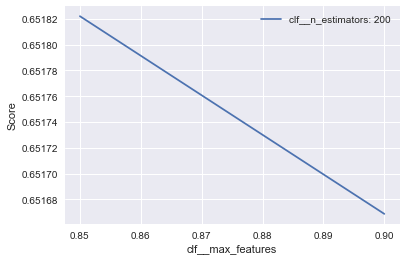

In [205]:
#result for 100 and 200 trees
optimize_params('clf__max_features','clf__n_estimators',result,parameter_grid)

In [54]:
#optimize_params('clf__max_features','clf__max_depth',result,parameter_grid)

In [206]:
# OOB score
result['best_estimator'].named_steps['clf'].oob_score_

0.61599761557406618

In [207]:
dump_pickle_model(result,name)

In [208]:
y_proba  = result['best_estimator'].predict_proba(X_test[features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[features])

Classification report on testing data
             precision    recall  f1-score   support

    On time       0.87      0.62      0.72     51831
    Delayed       0.27      0.61      0.37     11917

avg / total       0.76      0.62      0.66     63748

Confusion matrix


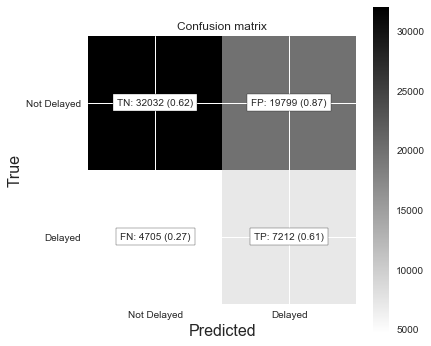

In [209]:
df_result = evaluate_model(y_test,y_pred,y_proba,description=name)
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

C:\Users\micakova\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:152: RuntimeWarning: invalid value encountered in true_divide


Max F1 on testing data: 0.37146445616679225

0.805426439479


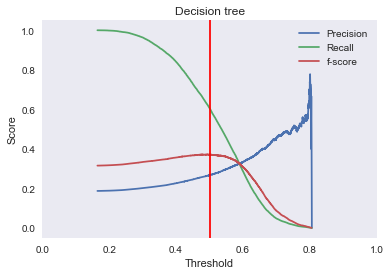

In [210]:
dict_precision_recall_f = plot_precision_recall_f(y_test, y_proba,description='Decision tree')
print(max(dict_precision_recall_f['thresholds']))
plt.axvline(0.5,color='r');

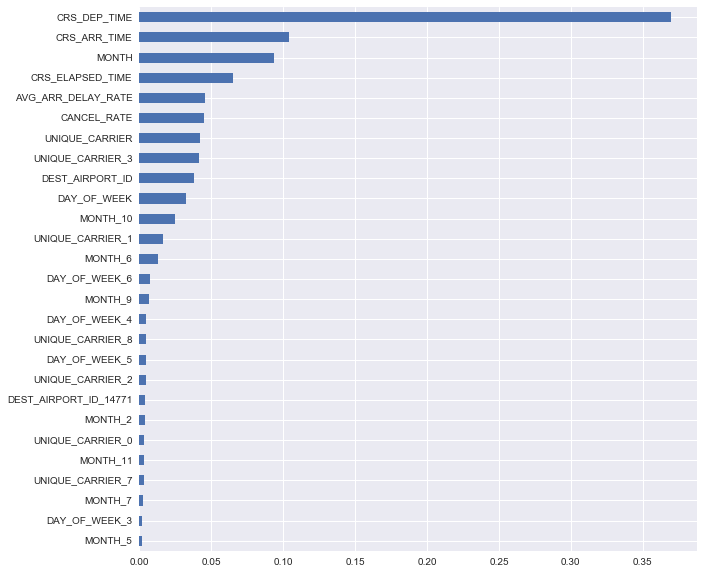

In [223]:
#get feature importance from pickle
save_models_to = 'C:\\Users\\micakova\\Experiments\\Pokusy\\Search\\models\\'
model_pickle = pickle.load(open(save_models_to + 'Random_forest_balanced_wo_dummies'+".pickle", 'rb'))
model_pickle['best_estimator'].named_steps['clf'].feature_importances_
feat_importances = pd.Series(data=model_pickle['best_estimator'].named_steps['clf'].feature_importances_, index=features).sort_values(ascending=True)
feat_importances[feat_importances>0.002].plot(kind='barh',figsize=(10,10));

AUC on test data: 0.66


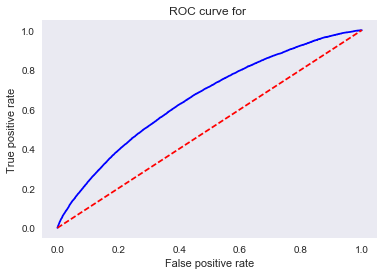

In [224]:
roc_result_ = plot_roc_curve(y_test, y_proba)
roc_result[name] = roc_result_

**Intermittent model evaluation**

Before trying out algorithms, I will evaluate the ones I tried so far. Random forest exhibits the best performance closely followed by logistic regression.  <br> As a next step, I will explore a few different algorithms to see if they have better performance.

**Receiver operating characteristics**

DecisionTree_unweighted_wodummies
DecisionTree_weighted_dummies
Random_forest_balanced_wo_dummies
Logit_weighted_wdummies


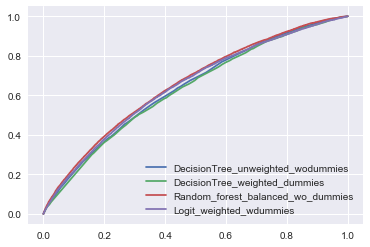

In [255]:
for key in roc_result.keys():
    print(key)
    plt.plot(roc_result[key]['FPR'],roc_result[key]['TPR'],label=key)
    plt.legend()

In [256]:
pd.read_csv('evaluation_result.csv')

,model,accuracy,f1-score,precision,recall,roc_auc_score
0,DecisionTree_weighted_wodummies,0.596925,0.366806,0.261140,0.616101,0.641139
1,DecisionTree_unweighted_wodummies,0.813061,0.000000,0.000000,0.000000,0.639094
2,DecisionTree_weighted_dummies,0.561633,0.353858,0.244223,0.642108,0.630510
3,Random_forest_balanced_wo_dummies,0.615611,0.370530,0.267002,0.605186,0.656459
4,Logit_unweighted_dummies,0.813029,0.000335,0.333333,0.000168,0.646254
5,Logistic regression w/dummies,0.603093,0.367513,0.261723,0.616850,0.646450


**SVM** <br>
<br>
I tried SVM with two different combination of parametres on a subsample of the dataset with dummy features. SVM is not a suitable model due to its fit time complexity. 
It does not seem to bring enough performance improvement either.<br>
<br>


In [ ]:
name = 'SVC'

In [ ]:
from sklearn.svm import SVC
verbose = 0
clf = SVC()
parameter_grid = {
    
    'clf__kernel': ['rbf'],
    'clf__C': [10,100],
    'clf__gamma': [0.1,0.01] 
}

pipeline = Pipeline([
    ('sca', sca),
    #('pca', pca),
    ('clf', clf)])

#scoring_method = metrics.roc_auc_score
scoring_method = 'roc_auc'
#scoring_method = 'recall'

result = do_grid_search(pipeline,X_train[dummy_features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv,seed=42)

**XGBoost**
<br>
First off, I tune the max_depth and min_child_weight parametres. The optimal max_depth seems to be 8. I set min_child_weight to 10. After tuning the gamma, learning rate and n_estimators, the best ROC score I get is ~ 61. This is less than the Random Forest score, so I will not do any further tuning as it is unlikely to raise the performance significantly.. 

In [174]:
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [40]:
name = 'XGB'

verbose = 0
scoring_method = 'roc_auc'
clf = XGBClassifier()
parameter_grid = {
    'clf__max_depth': [5]
    ,'clf__subsample': [0.8]
    ,'clf__n_estimators': [1000,2000] # [1800,2000]
    ,'clf__min_child_weight': [3.5]
    ,'clf__gamma': [0.1] 
    ,'clf__colsample_bytree': [0.6]
    ,'clf__scale_pos_weight':[1]
    ,'clf__learning_rate':[0.1,0.01]
    ,'clf__reg_alpha': [0.01]                              
    }

pipeline = Pipeline([
    #('sca', sca),
    ('clf', clf)])

scoring_method = 'roc_auc'
#scoring_method = 'recall'

result = do_grid_search(pipeline,X_train[dummy_features],y_train,parameter_grid,scoring_method = scoring_method,cv=cv,seed=42)

Performing grid search...
pipeline: ['clf']
Best cross-validation score: 0.661215 using {'clf__colsample_bytree': 0.6, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__min_child_weight': 3.5, 'clf__n_estimators': 1000, 'clf__reg_alpha': 0.01, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}
Best parameter set:
clf__colsample_bytree: 0.6
clf__gamma: 0.1
clf__learning_rate: 0.01
clf__max_depth: 5
clf__min_child_weight: 3.5
clf__n_estimators: 1000
clf__reg_alpha: 0.01
clf__scale_pos_weight: 1
clf__subsample: 0.8


parameter 1: clf__min_child_weight,[3, 5, 7]; parameter 2: clf__max_depth,[6, 7]
Best: 0.646220 using {'clf__colsample_bytree': 0.8, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__min_child_weight': 3, 'clf__n_estimators': 500, 'clf__scale_pos_weight': 1}


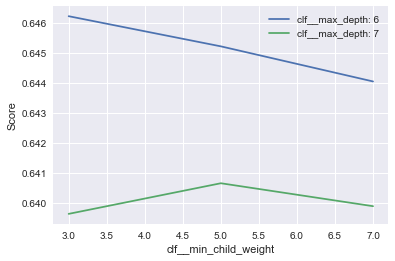

In [33]:
#optimize_params('clf__min_child_weight','clf__max_depth',result,parameter_grid)

parameter 1: clf__n_estimators,[300, 400, 1000, 2000]; parameter 2: clf__learning_rate,[0.001, 0.01]
Best: 0.609088 using {'clf__colsample_bytree': 0.4, 'clf__gamma': 0.4, 'clf__learning_rate': 0.001, 'clf__max_depth': 8, 'clf__min_child_weight': 10, 'clf__n_estimators': 2000, 'clf__scale_pos_weight': 1}


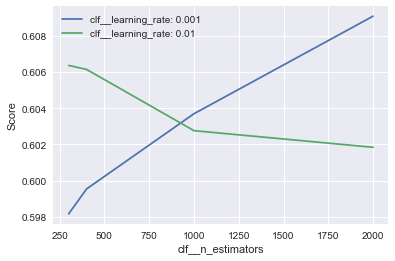

In [367]:
#optimize_params('clf__n_estimators','clf__learning_rate',result,parameter_grid)

In [41]:
dump_pickle_model(result,name)

Classification report on testing data
             precision    recall  f1-score   support

    On time       0.81      1.00      0.90     51831
    Delayed       0.64      0.00      0.00     11917

avg / total       0.78      0.81      0.73     63748

Confusion matrix


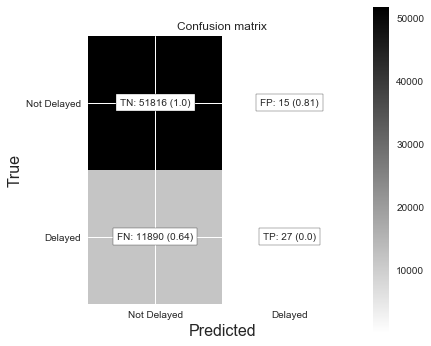

In [44]:
#result['grid_result'].cv_results_['params']
y_proba  = result['best_estimator'].predict_proba(X_test[dummy_features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[dummy_features])
df_result = evaluate_model(y_test,y_pred,y_proba,description=name)
with open('evaluation_result.csv', 'a') as f:
    df_result.to_csv(f, header=False)

Max F1 on testing data: 0.37745615888442846

0.586998999119


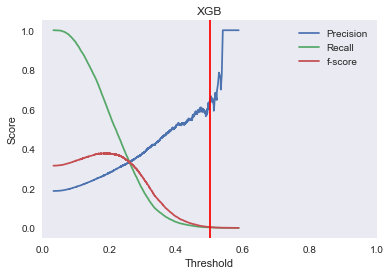

In [46]:
dict_precision_recall_f = plot_precision_recall_f(y_test, y_proba,description=name)
print(max(dict_precision_recall_f['thresholds']))
plt.axvline(0.5,color='r');

AUC on test data: 0.66


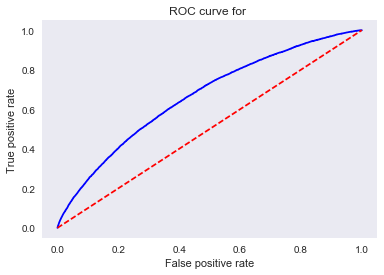

In [47]:
roc_result_ = plot_roc_curve(y_test, y_proba)

In [81]:
dump_pickle_model(result,name)

**Algorithm comparison**

In [49]:
final_result_csv=pd.read_csv('evaluation_result.csv')

In [50]:
final_result_csv

,model,accuracy,f1-score,precision,recall,roc_auc_score
0,DecisionTree_weighted_wodummies,0.596925,0.366806,0.261140,0.616101,0.641139
1,DecisionTree_unweighted_wodummies,0.813061,0.000000,0.000000,0.000000,0.639094
2,DecisionTree_weighted_dummies,0.561633,0.353858,0.244223,0.642108,0.630510
3,Random_forest_balanced_wo_dummies,0.615611,0.370530,0.267002,0.605186,0.656459
4,Logit_unweighted_dummies,0.813029,0.000335,0.333333,0.000168,0.646254
5,Logistic regression w/dummies,0.603093,0.367513,0.261723,0.616850,0.646450
6,XGB,0.813249,0.004515,0.642857,0.002266,0.664659


XGBoost has the highest ROC. 

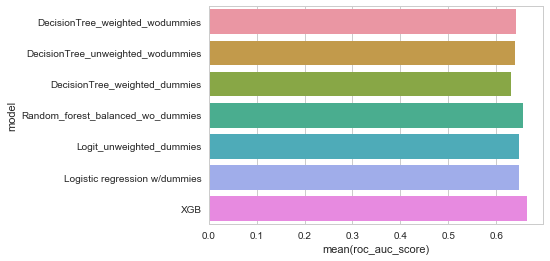

In [79]:
ax = sns.barplot(x="roc_auc_score",y="model", data=final_result_csv)

XGBoost has marginally better performance than Logistic regression and Random forest classifier in terms of ROC. 

In [82]:
save_models_to = 'C:\\Users\\micakova\\Experiments\\Pokusy\\Search\\models\\'
model_pickle = pickle.load(open(save_models_to + name+".pickle", 'rb'))
model_pickle['best_estimator'].named_steps['clf']

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=3.5, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [ ]:
Precision and recall  can be changed by varyi

In [83]:
y_proba  = result['best_estimator'].predict_proba(X_test[dummy_features])[:, 1]
y_pred = result['best_estimator'].predict(X_test[dummy_features])

Classification report on testing data
             precision    recall  f1-score   support

    On time       0.87      0.65      0.75     51831
    Delayed       0.28      0.58      0.38     11917

avg / total       0.76      0.64      0.68     63748

Confusion matrix


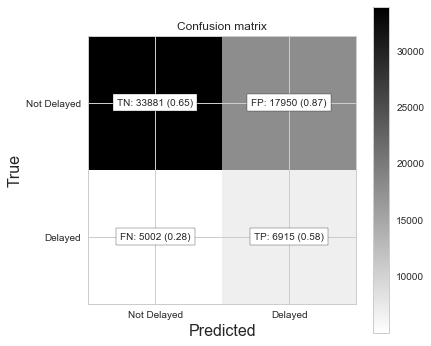

,accuracy,f1-score,precision,recall,roc_auc_score
NaN,0.639957,0.375999,0.278102,0.580263,0.664659


In [89]:
threshold = 0.2
new_y_pred = [1 if _ > threshold else 0 for _ in y_proba]
evaluate_model(y_test,new_y_pred,y_proba,description=None)

**Ideas for further analysis**

**Adding explanatory variables**: <br>
<br>
    -weather trend information - periods of rain or extremely cold weather can lead to flight delays. I could use historical averages of precipitation and temperature <br>
    <br>
    -weather forecast data (available only a few days before departure)  <br>
    <br>
    -information about the number of passangers per flight as a % of total number of available seats - full flights could be delayed more often <br>
    <br>

**Other ideas:** <br>
 <br>
-creating separate models for each airline/flight path/airport to see if that improves the accuracy of our prediction<br>
<br>
-explore the data with network-based algorithms. The analysis suggests that there is a domino effect with flight delays - flights earlier in the day delay later flights.<br>
<br>
    